In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

# Code

In [2]:
# read in the data
fake_df = pd.read_csv('fake_data.csv')
# print the tail 
print(fake_df.tail())

      subject cohort  week_num        Mon        Tue        Wed        Thu  \
18318  PD_200     PD        41  15.422691  20.389540  15.746726  20.793219   
18319  PD_200     PD        42  23.690296  20.210504  21.592530  17.348857   
18320  PD_200     PD        43  19.142177  25.329346  20.938469  19.919805   
18321  PD_200     PD        44  16.262621  13.810056  12.148032  16.259669   
18322  PD_200     PD        45  21.284227  14.601011  17.206655  14.034752   

             Fri        Sat        Sun  mean_activity  
18318   9.272010  24.687426  22.093220      18.343547  
18319  18.745112  19.050198  18.771433      19.915561  
18320  21.367710  24.831546  21.268272      21.828189  
18321  16.174192  19.281996  21.967300      16.557695  
18322  19.537480  23.902191  17.281258      18.263939  


In [3]:
# how many observations for each user?
user_counts = fake_df.groupby('subject').size()
print(user_counts)

subject
HC_1      46
HC_10     48
HC_100    46
HC_101    45
HC_102    40
          ..
PD_95     42
PD_96     46
PD_97     42
PD_98     43
PD_99     41
Length: 400, dtype: int64


# Prepare data

In [4]:

# 1. Data Preparation
def prepare_data(df):
    """Convert dataframe to tensors ready for training"""
    # Get unique subjects and split by cohort
    subjects = df['subject'].unique()
    
    # Lists to store our sequences and labels
    all_sequences = []
    all_labels = []
    all_time_points = []
    subject_ids = []
    
    for subject in subjects:
        subject_data = df[df['subject'] == subject].sort_values('week_num')
        features = subject_data[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].values
        cohort_label = 1 if subject_data['cohort'].iloc[0] == 'PD' else 0
        
        # Only append the full sequences for each unique subject 
        all_sequences.append(features)
        all_labels.append(cohort_label)
        all_time_points.append(len(features))
        subject_ids.append(subject)
    
    return all_sequences, all_labels, all_time_points, subject_ids


In [5]:
# prepare the data
sequences, labels, time_points, subject_ids = prepare_data(fake_df)

# Select a batch from the data

In [6]:

# 2. Batch Processing Function
def create_dataloader(sequences, labels, time_points, batch_size=10):
    """Create DataLoader with padded sequences"""
    # Sort by sequence length (for packing)
    sorted_idx = sorted(range(len(sequences)), key=lambda i: len(sequences[i]), reverse=True)
    
    sequences = [sequences[i] for i in sorted_idx]
    labels = [labels[i] for i in sorted_idx]
    time_points = [time_points[i] for i in sorted_idx]
    
    # Get sequence lengths
    lengths = [len(seq) for seq in sequences]
    
    # Pad sequences
    max_len = max(lengths)
    padded_sequences = []
    
    # post padding: adding weeks of zeros to the end of the sequence
    # to make all sequences the same length of the longest sequence (52)
    for seq in sequences:
        padded_seq = np.zeros((max_len, seq.shape[1]))
        padded_seq[:len(seq)] = seq
        padded_sequences.append(padded_seq)
    
    # Convert to tensors
    X = torch.FloatTensor(padded_sequences)
    y = torch.FloatTensor(labels)
    # lengths should be a tensor from 1 to 52, evenly spaced 
    t_s = range(1, max_len + 1) 
    lengths = torch.FloatTensor(t_s) 
    time_weights = torch.FloatTensor(time_points)

    # To match Hemant's code, transpose the data
    X = X.transpose(0, 1)  # (num_weeks, num_subjects, num_features)
    
    # Create TensorDataset and DataLoader
    # dataset = TensorDataset(X, lengths, y, time_weights)
    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # return dataloader
    return X, lengths, y, time_weights



In [144]:
# write an equivalent function, but adding dataloader and using pad_sequence 


In [7]:
# observe the tensors
X, lengths, y, time_weights = create_dataloader(sequences, labels, time_points, batch_size=10)
# print the shapes
print("X shape:", X.shape)
print("Labels shape:", y.shape)
print("Lengths shape:", lengths.shape)
print("Time Weights shape:", time_weights.shape)


X shape: torch.Size([52, 400, 7])
Labels shape: torch.Size([400])
Lengths shape: torch.Size([52])
Time Weights shape: torch.Size([400])


C:\Users\Felice Dong\AppData\Local\Temp\ipykernel_15944\963685970.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\Users\dev-admin\Desktop\build42\libtorch_1738271764196\work\torch\csrc\utils\tensor_new.cpp:281.)
  X = torch.FloatTensor(padded_sequences)


In [8]:
print(lengths)
print(time_weights)

tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
        43., 44., 45., 46., 47., 48., 49., 50., 51., 52.])
tensor([52., 52., 52., 52., 52., 52., 52., 52., 52., 52., 52., 52., 52., 52.,
        52., 52., 52., 52., 52., 52., 52., 52., 52., 52., 52., 52., 52., 52.,
        52., 52., 51., 51., 51., 51., 51., 51., 51., 51., 51., 51., 51., 51.,
        51., 51., 51., 51., 51., 51., 51., 51., 51., 51., 51., 51., 51., 50.,
        50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
        50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
        49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49.,
        49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 48.,
        48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48.,
     

In his code, each subject is observed at 100 evenly spaced time points. His 100 observations are akin to 100 weeks of observations in our case. ie 100 consecutive measurements where each contains a full week's worth of data. 

In our fake data, the maximum length of weekly observations is 52. After padding, each subject should have 52 weeks of data, which should be the first dimension of the x tensor. This means that each subject has 52 observations, with some of them being padded with zeros.

The number of subjects should also be 400, with 200 subjects in each group. This should be the second dimension of the x tensor.

The last dimension of the x tensor should be 7, which is the number of features.

REVISIT LATER TO IMPLEMENT DATALOADER

1.0


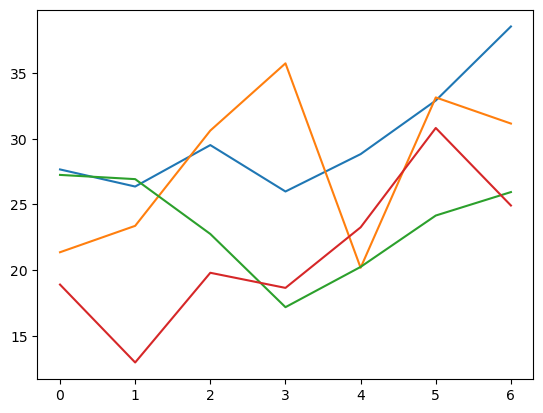

In [9]:
print(y[399].item())
# visualize the activity for the last subject, a PD subject 
tmp = X[:,399,:].detach().numpy()
for i in range(0, 52, 13):
    plt.plot(tmp[i,:])
plt.show()

In [10]:
# Function to get random batches for stochastic optimization
def get_batch(x_data, y_data,batch_size):
    n_sequences = x_data.size(1)
    # Randomly select indices for the batch
    batch_indices = torch.randperm(n_sequences)[:batch_size]
    # Sample the batch
    x_batch = x_data[:, batch_indices, :]
    y_batch = y_data[batch_indices]
    return x_batch,y_batch, batch_indices

# Create LSTM 

In [11]:
# 3. LSTM Model 
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False)
        self.lin = nn.Linear(hidden_size, output_size) 

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        # apply linear layer to each time step 
        weight = self.lin(lstm_out)
        # denominator to normalize the weights 
        epsilon = 1e-6
        weight_denom = torch.sum(torch.abs(weight), axis=2) + epsilon
        # normalize the weights
        # torch.mul is the element-wise multiplication
        output = torch.sum(torch.mul(weight, x), axis=2) / weight_denom
        return output, weight

In [12]:
# 4. Separation Loss
def loss_fn(output, weight, labels, time_weights):
    y1_idx = torch.nonzero(labels > 0.5).flatten()
    y0_idx = torch.nonzero(labels < 0.5).flatten()

    epsilon = 1e-6
    y1_sum = torch.sum(output[:, y1_idx], axis=1) / (torch.numel(y1_idx) + epsilon) # numel is the number of elements in the tensor
    y1_sum = y1_sum*(1+time_weights)
    y1_sum = torch.sum(y1_sum)

    y0_sum = torch.sum((output[:, y0_idx])**2) / (torch.numel(y0_idx) + epsilon)
                       
    #y0_sum = torch.sum(output[:, y0_idx], axis=1) / (torch.numel(y0_idx) + epsilon)
    #y0_sum = torch.sum(y0_sum)

    w_std = torch.std(weight.flatten())

    # the weight is multiplied by a factor of 20 to make it more significant
    # return -y1_sum + y0_sum + 20.0*w_std
    return -y1_sum + y0_sum # without regularization


# Training

In [13]:
input_size = 7 
hidden_size = 20
output_size = 7
num_layers = 2

model = LSTMModel(input_size, hidden_size, output_size, num_layers)

In [14]:
# 5. Training Loop
def train_model(model, X, lengths, y, num_epochs=300, batch_size=50, lr=0.0003):
    """Train the LSTM model"""

    # debugging statements
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"lengths shape: {lengths.shape}")
    
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()

        # Get a random batch
        x_batch, y_batch, batch_indices = get_batch(X, y, batch_size)

        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output, weight = model(x_batch)
        
        # Compute loss
        loss = loss_fn(output, weight, y_batch, lengths)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

In [15]:
# train the model 
train_model(model, X, lengths, y, num_epochs=10000, batch_size=50, lr=0.0003)

X shape: torch.Size([52, 400, 7])
y shape: torch.Size([400])
lengths shape: torch.Size([52])
Epoch [10/10000], Loss: -2847.4165
Epoch [20/10000], Loss: -3901.4712
Epoch [30/10000], Loss: -4881.1592
Epoch [40/10000], Loss: -5706.0117
Epoch [50/10000], Loss: -6072.5806
Epoch [60/10000], Loss: -6886.6768
Epoch [70/10000], Loss: -9695.0625
Epoch [80/10000], Loss: -9999.0645
Epoch [90/10000], Loss: -14122.2275
Epoch [100/10000], Loss: -14952.9492
Epoch [110/10000], Loss: -16234.9980
Epoch [120/10000], Loss: -18357.7734
Epoch [130/10000], Loss: -18442.7988
Epoch [140/10000], Loss: -20565.4941
Epoch [150/10000], Loss: -20137.5547
Epoch [160/10000], Loss: -20495.7461
Epoch [170/10000], Loss: -19835.2402
Epoch [180/10000], Loss: -21287.8320
Epoch [190/10000], Loss: -22207.2969
Epoch [200/10000], Loss: -22882.0645
Epoch [210/10000], Loss: -22729.7539
Epoch [220/10000], Loss: -23957.9180
Epoch [230/10000], Loss: -22151.5137
Epoch [240/10000], Loss: -22540.5059
Epoch [250/10000], Loss: -23366.3438

torch.Size([52, 400])


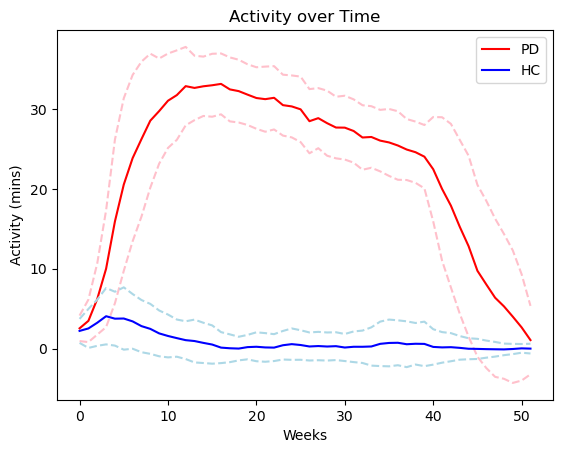

2.1030428


In [ ]:
# plotting

output,weight=model(X)
print(output.shape)
y1_index=torch.nonzero(y>0.5).flatten()
out=output[:,y1_index]
output_np=out.detach().numpy()
output_mean=np.mean(output_np,axis=1)
output_std=np.std(output_np,axis=1)
plt.plot(output_mean, color='red', label='PD')
plt.plot(output_mean+output_std, color='pink', linestyle='--')
plt.plot(output_mean-output_std, color='pink', linestyle='--')

y0_index=torch.nonzero(y<=0.5).flatten()
out=output[:,y0_index]
output_np=out.detach().numpy()
output_mean=np.mean(output_np,axis=1)
output_std=np.std(output_np,axis=1)
plt.plot(output_mean, color='blue', label='HC')
plt.plot(output_mean+output_std, color='lightblue', linestyle='--')
plt.plot(output_mean-output_std, color='lightblue', linestyle='--')
plt.xlabel('Weeks')
plt.ylabel('Index')
plt.title('LSTM Model Output (Progression Over Time)')
plt.legend()
plt.show()

print(np.mean(output_std))

The way I generated fake data, all subjects have between 40 to 52 weeks of ambulatory data. All subjets that have less than the maximum number of weeks of data (52) are padded with zeros at the end. This is evident in the graph above. It seems like up until week 40, it's fairly stable and there seems to be good separation between the two groups. After week 40, the two groups start to converge and the separation is not as clear. 

So, in summary, the 0s are affecting the model's ability to learn from the data.

I read that the LSTM model is able to mask data, but must still be trained with the same lengthed data. So when it comes to real data, I can zero pad and then use masks to ignore weeks with 0s. Hopefully, this way, the model only learns from relevant weeks with data. 

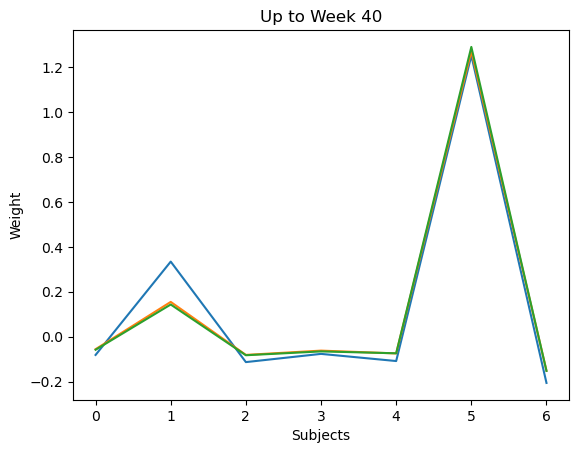

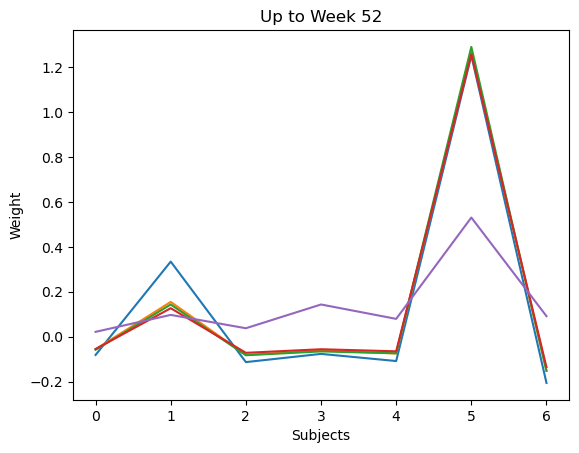

In [95]:
w = torch.mean(weight, axis=1)

for i in range(10,40,10):
    tmp=w[i,:].detach().numpy()
    tmp=tmp/np.sum(tmp)
    plt.plot(tmp)
    # labels
    plt.title("Up to Week 40")
    plt.xlabel("Subjects")
    plt.ylabel("Weight")
plt.show()

for i in range(10,52,10):
    tmp=w[i,:].detach().numpy()
    tmp=tmp/np.sum(tmp)
    plt.plot(tmp)
    # labels
    plt.title("Up to Week 52")
    plt.xlabel("Subjects")
    plt.ylabel("Weight")
plt.show()

The above aligns with how I generated data. I made weekdays consistent while varying weekend activity with Saturday being the most active day.

# to dos 
- Add a dataloader
- generatte progression indices 
- visualize the separation of the two groups

In [ ]:

# 5. Training function using dataloader REVISIT
def train_model_loader(model, dataloader, optimizer, num_epochs=50):
    model.train()
    
    # Track metrics
    history = {
        'loss': [],
        'pd_mean': [],
        'hc_mean': [],
        'separation': []
    }
    
    # Add MSE loss for regularization
    mse_loss = nn.MSELoss()
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        all_outputs = []
        all_labels = []
        
        for batch_idx, (sequences, lengths, labels, time_weights) in enumerate(dataloader):
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(sequences, lengths)
            
            # Store for metrics calculation
            all_outputs.append(outputs.detach())
            all_labels.append(labels)
            
            # Primary loss: separation between PD and HC
            sep_loss = separation_loss(outputs, labels)
            
            # Add regularization: push PD outputs higher (closer to 1) and HC outputs lower (closer to 0)
            # This ensures non-zero initialization
            target_values = labels.clone()
            reg_loss = mse_loss(outputs, target_values)
            
            # Combined loss with regularization
            combined_loss = sep_loss + 0.1 * reg_loss
            
            # Apply time weighting - later timepoints matter more
            time_weight_factor = 1.0 + torch.log1p(time_weights) / 10.0
            weighted_loss = combined_loss * torch.mean(time_weight_factor)
            
            # Backward pass
            weighted_loss.backward()
            optimizer.step()
            
            epoch_loss += weighted_loss.item()
        
        # Calculate metrics for this epoch
        all_outputs = torch.cat(all_outputs)
        all_labels = torch.cat(all_labels)
        
        pd_mask = (all_labels == 1).squeeze()
        hc_mask = (all_labels == 0).squeeze()
        
        # Ensure we have samples from both groups before calculating means
        if pd_mask.any() and hc_mask.any():
            pd_mean = torch.mean(all_outputs[pd_mask]).item()
            hc_mean = torch.mean(all_outputs[hc_mask]).item()
            separation = pd_mean - hc_mean
        else:
            pd_mean = 0
            hc_mean = 0
            separation = 0
        
        # Save metrics
        history['loss'].append(epoch_loss / len(dataloader))
        history['pd_mean'].append(pd_mean)
        history['hc_mean'].append(hc_mean)
        history['separation'].append(separation)
        
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {history["loss"][-1]:.4f}, ' +
                  f'PD: {pd_mean:.4f}, HC: {hc_mean:.4f}, Separation: {separation:.4f}')
    
    return model, history


# Try the model above on enhanced fake data 

In [96]:
enhanced_data = pd.read_csv('enhanced_fake_data.csv')
print(enhanced_data.tail())

      subject cohort       subgroup  week_num        date  month        Mon  \
18413  PD_200     PD  rapid_decline        43  2023-10-22     10  12.180682   
18414  PD_200     PD  rapid_decline        44  2023-10-29     10   6.318736   
18415  PD_200     PD  rapid_decline        45  2023-11-05     11  10.969956   
18416  PD_200     PD  rapid_decline        46  2023-11-12     11   7.031633   
18417  PD_200     PD  rapid_decline        47  2023-11-19     11   6.020245   

             Tue        Wed       Thu        Fri        Sat       Sun  \
18413   3.205703   6.434392  8.717928   7.071271  11.867912  8.544214   
18414   7.682095   1.918044  6.826817   6.494815  10.577110  8.873641   
18415  11.193979  10.420175  5.953746  11.710343   5.218916  6.116481   
18416  10.482157   9.270316  8.992806   5.044355   8.898817  4.227659   
18417   8.038012   2.471093  9.579829  10.492384   8.709737  8.410412   

      decline_type  weekly_avg  
18413  exponential    8.288872  
18414  exponential  

In [97]:
# Prep the data
sequences, labels, time_points, subject_ids = prepare_data(enhanced_data)

# Create tensors
X, lengths, y, time_weights = create_dataloader(sequences, labels, time_points, batch_size=10)
# verify shapes 
print("X shape:", X.shape)
print("Labels shape:", y.shape)
print("Lengths shape:", lengths.shape)

# training 
# params 
input_size = 7
hidden_size = 20
output_size = 7
num_layers = 2
# Create the model
model2 = LSTMModel(input_size, hidden_size, output_size, num_layers)
train_model(model2, X, lengths, y, num_epochs=50000)


X shape: torch.Size([52, 400, 7])
Labels shape: torch.Size([400])
Lengths shape: torch.Size([52])
X shape: torch.Size([52, 400, 7])
y shape: torch.Size([400])
lengths shape: torch.Size([52])
Epoch [10/50000], Loss: -2110.6541
Epoch [20/50000], Loss: -3476.9036
Epoch [30/50000], Loss: -4962.8047
Epoch [40/50000], Loss: -7148.4175
Epoch [50/50000], Loss: -10400.8867
Epoch [60/50000], Loss: -10080.5293
Epoch [70/50000], Loss: -8952.9834
Epoch [80/50000], Loss: -11064.3057
Epoch [90/50000], Loss: -11678.8271
Epoch [100/50000], Loss: -10117.8301
Epoch [110/50000], Loss: -11006.1494
Epoch [120/50000], Loss: -10663.0928
Epoch [130/50000], Loss: -11487.1182
Epoch [140/50000], Loss: -11916.5293
Epoch [150/50000], Loss: -12929.5352
Epoch [160/50000], Loss: -12865.0137
Epoch [170/50000], Loss: -13574.9043
Epoch [180/50000], Loss: -14161.0791
Epoch [190/50000], Loss: -13424.9326
Epoch [200/50000], Loss: -12909.8584
Epoch [210/50000], Loss: -15441.4668
Epoch [220/50000], Loss: -13294.1230
Epoch [23

torch.Size([52, 400])


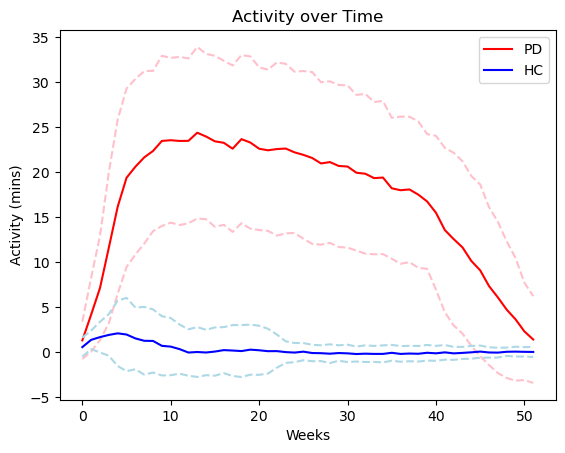

1.6498693


In [ ]:
# plotting 
output,weight=model2(X)
print(output.shape)
y1_index=torch.nonzero(y>0.5).flatten()
out=output[:,y1_index]
output_np=out.detach().numpy()
output_mean=np.mean(output_np,axis=1)
output_std=np.std(output_np,axis=1)
# specify colors 
plt.plot(output_mean, color='red', label ='PD')
plt.plot(output_mean+output_std, color='pink', linestyle='dashed')
plt.plot(output_mean-output_std, color ='pink', linestyle='dashed')

y0_index=torch.nonzero(y<=0.5).flatten()
out=output[:,y0_index]
output_np=out.detach().numpy()
output_mean=np.mean(output_np,axis=1)
output_std=np.std(output_np,axis=1)
plt.plot(output_mean, color='blue', label ='HC')
plt.plot(output_mean+output_std, color='lightblue', linestyle='dashed')
plt.plot(output_mean-output_std, color ='lightblue', linestyle='dashed')
plt.xlabel('Weeks')
plt.ylabel('Index')
plt.title('LSTM Model Output (Progression Over Time)')
plt.legend()
plt.show()
print(np.mean(output_std))

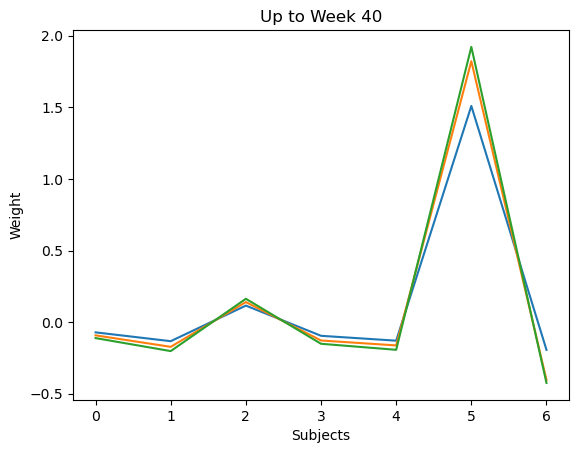

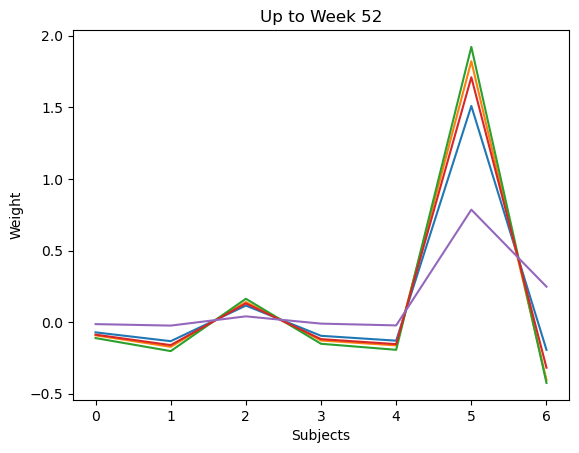

In [99]:
w2 = torch.mean(weight, axis=1)
for i in range(10,40,10):
    tmp=w2[i,:].detach().numpy()
    tmp=tmp/np.sum(tmp)
    plt.plot(tmp)
    # labels
    plt.title("Up to Week 40")
    plt.xlabel("Subjects")
    plt.ylabel("Weight")
plt.show()

for i in range(10,52,10):
    tmp=w2[i,:].detach().numpy()
    tmp=tmp/np.sum(tmp)
    plt.plot(tmp)
    # labels
    plt.title("Up to Week 52")
    plt.xlabel("Subjects")
    plt.ylabel("Weight")
plt.show()

# trying naive model with real data

In [128]:
# read in the data
real_df = pd.read_csv('ModelData.csv')
print(real_df.tail())

       subject   Mon   Tue   Wed   Thu   Fri   Sat   Sun  missing_count  \
15877    92490  19.0   9.0  17.0   5.0  19.0   4.0   4.0              0   
15878    92490  15.0  14.0  10.0  34.0   8.0  13.0   5.0              0   
15879    92490  13.0  36.0  23.0  17.5  22.0   9.0   8.0              1   
15880    92490   1.0  31.0   9.0   1.0  16.0  11.0  17.0              0   
15881    92490   8.0   4.0  24.0  12.0  16.0   8.0   2.0              0   

       Mon_deviation_lag  ...  Fri_deviation_lag  Sat_deviation_lag  \
15877          -0.318485  ...          -0.641927          -0.853534   
15878          -0.520075  ...          -0.280843          -1.243720   
15879          -0.721666  ...          -0.942830          -0.742052   
15880          -0.822461  ...          -0.100301          -0.965015   
15881          -1.427232  ...          -0.461385          -0.853534   

       Sun_deviation_lag  anomaly_count     cohort  year  week_num season  \
15877          -0.808184              0  Prod

In [101]:
# how many observations for each user?
user_counts = real_df.groupby('subject').size()

# sort in ascending order
user_counts = user_counts.sort_values(ascending=True)
print(user_counts)

# how many have at least 30 weeks of data?
print(user_counts[user_counts >= 30].count())
print(user_counts[user_counts >= 52].count())

# keep only those with at least 30 weeks of data
real_df_30 = real_df[real_df['subject'].isin(user_counts[user_counts >= 30].index)]

subject
4111       3
18491      5
75411      6
3216       7
41664      7
        ... 
59724    115
3517     117
72352    118
73134    119
4055     127
Length: 228, dtype: int64
210
176


In [129]:
# also only keep subjects whose cohort is PD and Control 
real_df_30 = real_df_30[real_df_30['cohort'].isin(['PD', 'Control'])]
# check the number of subjects
print(real_df_30['subject'].nunique()) # 107 not ideal, but revisit 

# check the number of PD and Control subjects 
print(real_df_30['cohort'].value_counts())

107
cohort
PD         6216
Control    1758
Name: count, dtype: int64


Before using `prepare_data`, the column week_num must be addressed first. It currently takes values 1 to 52, but that's within a year. Even if a week comes after 52, it restarts at 1 if it's a new year. However, the model needs to know that week 1 of year 2 is actually week 53. So, I need to create a new column that takes into account the year and week number. Also, I want to make sure that the first week of each subject is always 1, regardless of at what point in the year they start.

In [130]:
for subject, subject_data in real_df_30.groupby('subject'):
    # Get the first year for this subject
    first_year = subject_data['year'].min()

    # Calculate the number of weeks since the first year 
    subject_weeks = (subject_data['year'] - first_year) * 52 + subject_data['week_num']

    # Update the dataframe with the new week numbers
    real_df_30.loc[subject_data.index, 'week_num'] = subject_weeks

    # Offset the week numbers to start from 1
    real_df_30.loc[subject_data.index, 'week_num'] -= subject_weeks.min() - 1

In [131]:
# test out the code on the real data 
sequences, labels, time_points, subject_ids = prepare_data(real_df_30)
# Create tensors
X, lengths, y, time_weights = create_dataloader(sequences, labels, time_points, batch_size=10)
# verify shapes
print("X shape:", X.shape)
print("Labels shape:", y.shape)
print("Lengths shape:", lengths.shape)


X shape: torch.Size([127, 107, 7])
Labels shape: torch.Size([107])
Lengths shape: torch.Size([127])


In [132]:
# train the model
input_size = 7
hidden_size = 20
output_size = 7
num_layers = 2
# Create the model
model3 = LSTMModel(input_size, hidden_size, output_size, num_layers)
train_model(model3, X, lengths, y, num_epochs=5000)

X shape: torch.Size([127, 107, 7])
y shape: torch.Size([107])
lengths shape: torch.Size([127])
Epoch [10/5000], Loss: -9783.3242
Epoch [20/5000], Loss: 1931.2090
Epoch [30/5000], Loss: 1444.5332
Epoch [40/5000], Loss: -7437.3330
Epoch [50/5000], Loss: -12845.7373
Epoch [60/5000], Loss: -3247.9082
Epoch [70/5000], Loss: -20130.6641
Epoch [80/5000], Loss: -21947.6270
Epoch [90/5000], Loss: -33311.2891
Epoch [100/5000], Loss: -33973.0547
Epoch [110/5000], Loss: -35507.0898
Epoch [120/5000], Loss: -43050.3164
Epoch [130/5000], Loss: -42180.9297
Epoch [140/5000], Loss: -37723.1250
Epoch [150/5000], Loss: -50216.1602
Epoch [160/5000], Loss: -35677.2344
Epoch [170/5000], Loss: -39082.9922
Epoch [180/5000], Loss: -51305.0664
Epoch [190/5000], Loss: -38755.7188
Epoch [200/5000], Loss: -47457.6641
Epoch [210/5000], Loss: -50156.3594
Epoch [220/5000], Loss: -61885.3281
Epoch [230/5000], Loss: -49545.0117
Epoch [240/5000], Loss: -60407.5703
Epoch [250/5000], Loss: -67203.1328
Epoch [260/5000], Los

torch.Size([127, 107])


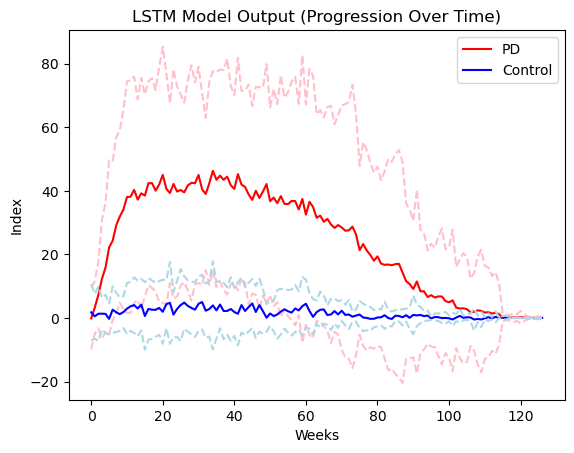

4.9376836


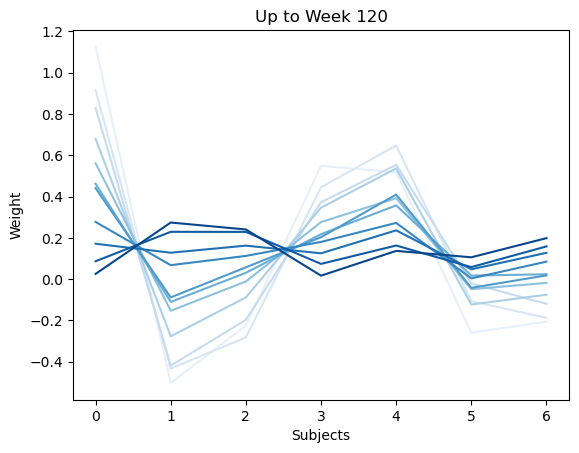

In [133]:
# plotting
# plot the output
output,weight=model3(X)
print(output.shape)
y1_index=torch.nonzero(y>0.5).flatten()
out=output[:,y1_index]
output_np=out.detach().numpy()
output_mean=np.mean(output_np,axis=1)
output_std=np.std(output_np,axis=1)
# specify colors
plt.plot(output_mean, color='red', label ='PD')
plt.plot(output_mean+output_std, color='pink', linestyle='dashed')
plt.plot(output_mean-output_std, color ='pink', linestyle='dashed')
y0_index=torch.nonzero(y<=0.5).flatten()
out=output[:,y0_index]
output_np=out.detach().numpy()
output_mean=np.mean(output_np,axis=1)
output_std=np.std(output_np,axis=1)
plt.plot(output_mean, color='blue', label ='Control')
plt.plot(output_mean+output_std, color='lightblue', linestyle='dashed')
plt.plot(output_mean-output_std, color ='lightblue', linestyle='dashed')
plt.xlabel('Weeks')
plt.ylabel('Index')
plt.title('LSTM Model Output (Progression Over Time)')
plt.legend()
plt.show()
print(np.mean(output_std))

# plot the weights
w3 = torch.mean(weight, axis=1)
for i in range(10,120,10):
    tmp=w3[i,:].detach().numpy()
    tmp=tmp/np.sum(tmp)
    plt.plot(tmp, color=plt.cm.Blues(i/120))
    # labels
    plt.title("Up to Week 120")
    plt.xlabel("Subjects")
    plt.ylabel("Weight")
plt.show()

# To-dos

- sort week-wise (highest to lowest actvity within a week)
- masking 
- see what happens if we only use 30 weeks of data, and up to 52

# Sorting by decreasing activity within a week

The idea is to sort the data by week number and then by activit over the week. This way, perhaps the model will learn to better capture the overall activity progression because it gets rid of some of the noise of day-to-day variability. Instead, it focuses on the overall activity level of each week. In other words, we are treating weekday labels as arbritrary demarcations of the week.

In [117]:
# modified data prep with sorted activity 

def prepare_data_sorted(df):
    """Convert dataframe to tensors with sorted activity levels per week"""
    # Get unique subjects and split by cohort
    subjects = df['subject'].unique()
    
    # Lists to store our sequences and labels
    all_sequences = []
    all_labels = []
    all_time_points = []
    subject_ids = []
    
    for subject in subjects:
        # sort the data by week_num
        subject_data = df[df['subject'] == subject].sort_values('week_num')

        # get raw features 
        features = subject_data[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].values
        # sort features in descending order
        sorted_features = np.sort(features, axis=1)[:, ::-1] # axis=1 sorts each row, ::-1 reverses the order
        
        # get cohort label
        cohort_label = 1 if subject_data['cohort'].iloc[0] == 'PD' else 0
        
        # Only append the full sequences for each unique subject 
        all_sequences.append(sorted_features)
        all_labels.append(cohort_label)
        all_time_points.append(len(sorted_features))
        subject_ids.append(subject)
    
    return all_sequences, all_labels, all_time_points, subject_ids

In [118]:
# prepare the data 
sequences, labels, time_points, subject_ids = prepare_data_sorted(real_df_30)
# Create tensors
X, lengths, y, time_weights = create_dataloader(sequences, labels, time_points, batch_size=10)
# verify shapes
print("X shape:", X.shape)
print("Labels shape:", y.shape)
print("Lengths shape:", lengths.shape)

# verify the data by printing out first sequence
print(sequences[0])
print(labels[0])


X shape: torch.Size([127, 107, 7])
Labels shape: torch.Size([107])
Lengths shape: torch.Size([127])
[[41.   39.   37.   32.   26.   15.    5.  ]
 [86.   59.   57.   48.   37.   22.   17.  ]
 [60.   43.   36.   26.   25.   14.   13.  ]
 [66.   52.   40.   39.   37.   18.   13.  ]
 [63.   60.   54.   54.   48.   32.   18.  ]
 [70.   67.   51.   42.   41.   40.   14.  ]
 [57.   44.   43.   42.   38.   30.   18.  ]
 [54.   54.   40.   39.   34.   32.   30.  ]
 [66.   63.   62.   39.   34.   34.   33.  ]
 [51.   42.   42.   42.   40.   39.   32.  ]
 [63.   53.   50.   31.   20.   13.   13.  ]
 [79.   73.   42.   36.   31.   25.   13.  ]
 [58.   52.   43.   42.   26.   24.   16.  ]
 [55.   39.   36.   30.   29.   28.   19.  ]
 [66.   64.   53.   45.   40.   27.   20.  ]
 [62.   56.   55.   42.   39.   37.   22.  ]
 [66.   57.   32.   31.   29.   17.   16.  ]
 [59.   48.   35.   35.   28.   22.   21.  ]
 [64.   51.   34.   30.   22.   17.    9.  ]
 [67.   40.   38.   34.   24.   17.   13.  ]


In [119]:
# train the model
input_size = 7
hidden_size = 20
output_size = 7
num_layers = 2
# Create the model
model3_sorted = LSTMModel(input_size, hidden_size, output_size, num_layers)
train_model(model3_sorted, X, lengths, y, num_epochs=50000)

X shape: torch.Size([127, 107, 7])
y shape: torch.Size([107])
lengths shape: torch.Size([127])
Epoch [10/50000], Loss: -2472.3774
Epoch [20/50000], Loss: -6300.8291
Epoch [30/50000], Loss: -12006.5781
Epoch [40/50000], Loss: -17150.4180
Epoch [50/50000], Loss: -20833.5215
Epoch [60/50000], Loss: -29213.0957
Epoch [70/50000], Loss: -34780.8594
Epoch [80/50000], Loss: -39934.4609
Epoch [90/50000], Loss: -43151.2891
Epoch [100/50000], Loss: -54453.0273
Epoch [110/50000], Loss: -58438.0703
Epoch [120/50000], Loss: -55407.6797
Epoch [130/50000], Loss: -54259.5430
Epoch [140/50000], Loss: -71709.4844
Epoch [150/50000], Loss: -76588.5000
Epoch [160/50000], Loss: -72097.8281
Epoch [170/50000], Loss: -86855.0625
Epoch [180/50000], Loss: -64220.3477
Epoch [190/50000], Loss: -78295.1875
Epoch [200/50000], Loss: -64895.6719
Epoch [210/50000], Loss: -64182.5547
Epoch [220/50000], Loss: -68598.7031
Epoch [230/50000], Loss: -61782.7305
Epoch [240/50000], Loss: -68484.4609
Epoch [250/50000], Loss: -93

torch.Size([127, 107])


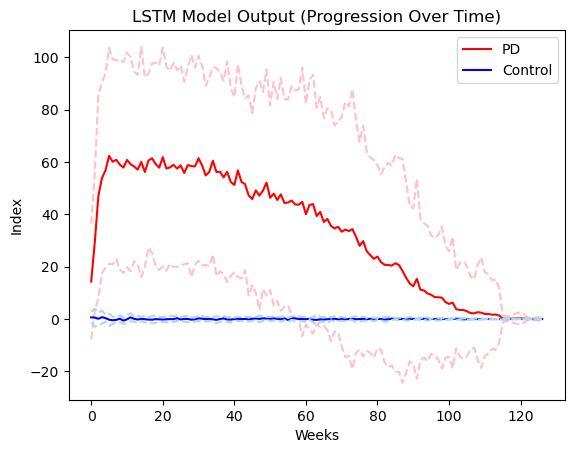

0.7625308


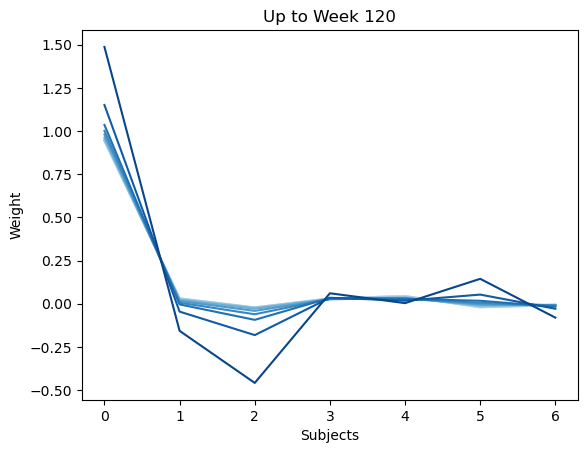

In [ ]:
# plotting
# plot the output
output,weight=model3_sorted(X)
print(output.shape)
y1_index=torch.nonzero(y>0.5).flatten()
out=output[:,y1_index]
output_np=out.detach().numpy()
output_mean=np.mean(output_np,axis=1)
output_std=np.std(output_np,axis=1)
# specify colors
plt.plot(output_mean, color='red', label ='PD')
plt.plot(output_mean+output_std, color='pink', linestyle='dashed')
plt.plot(output_mean-output_std, color ='pink', linestyle='dashed')
y0_index=torch.nonzero(y<=0.5).flatten()
out=output[:,y0_index]
output_np=out.detach().numpy()
output_mean=np.mean(output_np,axis=1)
output_std=np.std(output_np,axis=1)
plt.plot(output_mean, color='blue', label ='Control')
plt.plot(output_mean+output_std, color='lightblue', linestyle='dashed')
plt.plot(output_mean-output_std, color ='lightblue', linestyle='dashed')
plt.xlabel('Weeks')
plt.ylabel('Index')
plt.title('LSTM Model Output (Progression Over Time)')
plt.legend()
plt.show()
print(np.mean(output_std)) 

# plot the weights
w3_sorted = torch.mean(weight, axis=1)
for i in range(10,120,10):
    tmp=w3_sorted[i,:].detach().numpy()
    tmp=tmp/np.sum(tmp)
    plt.plot(tmp, color=plt.cm.Blues(i/120))
    # labels
    plt.title("Up to Week 120")
    plt.xlabel("Subjects")
    plt.ylabel("Weight")
plt.show()

# combined?

Another idea could be to feed in both simultaneously. The model would learn to capture both the overall activity level AND the day-to-day variability. This way, it can learn to distinguish between the two groups based on both aspects of the data.
- If weights for the sorted features (positions 8-14) are consistently higher, it suggests the overall activity profile is more informative than day-specific patterns
- If weights for certain days (positions 1-7) are higher, it suggests those specific days contain particularly important information
- Note, input size is now 14, not 7 because we are concatenating the two tensors.

In [121]:
def prepare_data_combined(df):
    """Convert dataframe to tensors with combined activity levels per week"""
    # Get unique subjects and split by cohort
    subjects = df['subject'].unique()
    
    # Lists to store our sequences and labels
    all_sequences = []
    all_labels = []
    all_time_points = []
    subject_ids = []
    
    for subject in subjects:
        # sort the data by week_num
        subject_data = df[df['subject'] == subject].sort_values('week_num')

        # get raw features 
        features = subject_data[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].values
        # sort features in descending order
        sorted_features = np.sort(features, axis=1)[:, ::-1]
        # concatenate the sorted features with the original features
        combined_features = np.concatenate((features, sorted_features), axis=1)

        # get cohort label
        cohort_label = 1 if subject_data['cohort'].iloc[0] == 'PD' else 0

        # Only append the full sequences for each unique subject
        all_sequences.append(combined_features)
        all_labels.append(cohort_label)
        all_time_points.append(len(combined_features))
        subject_ids.append(subject)
    return all_sequences, all_labels, all_time_points, subject_ids

In [ ]:
# prepare the data
sequences, labels, time_points, subject_ids = prepare_data_combined(real_df_30)
# Create tensors
X, lengths, y, time_weights = create_dataloader(sequences, labels, time_points, batch_size=10)
# verify shapes
print("X shape:", X.shape)
print("Labels shape:", y.shape)
print("Lengths shape:", lengths.shape)
# verify the data by printing out the first five weeks of the first sequence
print(sequences[0][:5])

X shape: torch.Size([127, 107, 14])
Labels shape: torch.Size([107])
Lengths shape: torch.Size([127])
[[ 5. 32. 15. 41. 37. 26. 39. 41. 39. 37. 32. 26. 15.  5.]
 [57. 48. 86. 37. 22. 59. 17. 86. 59. 57. 48. 37. 22. 17.]
 [26. 25. 60. 43. 13. 36. 14. 60. 43. 36. 26. 25. 14. 13.]
 [40. 39. 37. 18. 66. 52. 13. 66. 52. 40. 39. 37. 18. 13.]
 [48. 54. 18. 60. 63. 54. 32. 63. 60. 54. 54. 48. 32. 18.]]


In [125]:
# train the model
input_size = 14
hidden_size = 20
output_size = 14
num_layers = 2
# Create the model
model3_combined = LSTMModel(input_size, hidden_size, output_size, num_layers)
train_model(model3_combined, X, lengths, y, num_epochs=50000)

X shape: torch.Size([127, 107, 14])
y shape: torch.Size([107])
lengths shape: torch.Size([127])
Epoch [10/50000], Loss: 6550.5679
Epoch [20/50000], Loss: -17863.8008
Epoch [30/50000], Loss: -13499.3291
Epoch [40/50000], Loss: -16155.4648
Epoch [50/50000], Loss: -15915.0674
Epoch [60/50000], Loss: -18188.4004
Epoch [70/50000], Loss: -23955.9297
Epoch [80/50000], Loss: -23698.8262
Epoch [90/50000], Loss: -16207.6660
Epoch [100/50000], Loss: -16183.1436
Epoch [110/50000], Loss: -24658.6465
Epoch [120/50000], Loss: -38067.5000
Epoch [130/50000], Loss: -34770.7812
Epoch [140/50000], Loss: -39014.4570
Epoch [150/50000], Loss: -53330.1367
Epoch [160/50000], Loss: -51284.7344
Epoch [170/50000], Loss: -59237.6289
Epoch [180/50000], Loss: -65295.6523
Epoch [190/50000], Loss: -72487.3516
Epoch [200/50000], Loss: -77944.2734
Epoch [210/50000], Loss: -81549.9688
Epoch [220/50000], Loss: -71725.7656
Epoch [230/50000], Loss: -110010.1797
Epoch [240/50000], Loss: -88611.2188
Epoch [250/50000], Loss: -

torch.Size([127, 107])


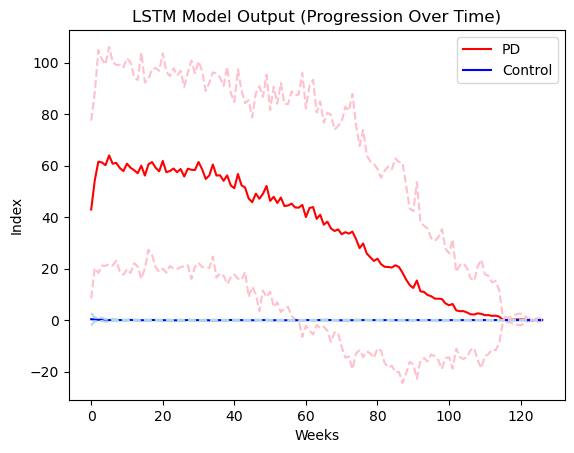

0.15323015


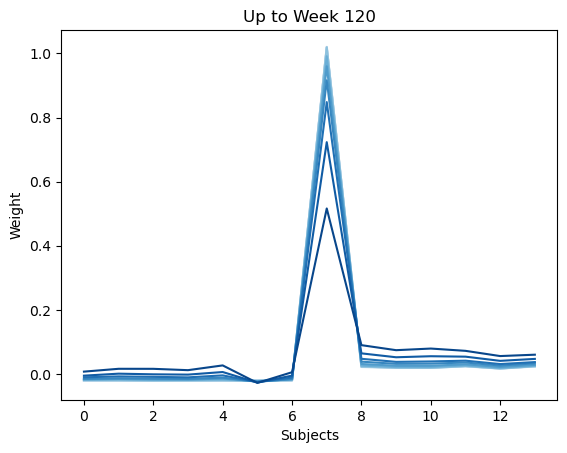

In [126]:
# Plotting 

# plot the output
output,weight=model3_combined(X)
print(output.shape)
y1_index=torch.nonzero(y>0.5).flatten()
out=output[:,y1_index]
output_np=out.detach().numpy()
output_mean=np.mean(output_np,axis=1)
output_std=np.std(output_np,axis=1)
# specify colors
plt.plot(output_mean, color='red', label ='PD')
plt.plot(output_mean+output_std, color='pink', linestyle='dashed')
plt.plot(output_mean-output_std, color ='pink', linestyle='dashed')
y0_index=torch.nonzero(y<=0.5).flatten()
out=output[:,y0_index]
output_np=out.detach().numpy()
output_mean=np.mean(output_np,axis=1)
output_std=np.std(output_np,axis=1)
plt.plot(output_mean, color='blue', label ='Control')
plt.plot(output_mean+output_std, color='lightblue', linestyle='dashed')
plt.plot(output_mean-output_std, color ='lightblue', linestyle='dashed')
plt.xlabel('Weeks')
plt.ylabel('Index')
plt.title('LSTM Model Output (Progression Over Time)')
plt.legend()
plt.show()
print(np.mean(output_std))

# plot the weights
w3_combined = torch.mean(weight, axis=1)
for i in range(10,120,10):
    tmp=w3_combined[i,:].detach().numpy()
    tmp=tmp/np.sum(tmp)
    plt.plot(tmp, color=plt.cm.Blues(i/120))
    # labels
    plt.title("Up to Week 120")
    plt.xlabel("Subjects")
    plt.ylabel("Weight")
plt.show()

## things to try
- masking still
- different time scales as opposed to weeks 
- rolling averages? windows? 
- swapping neighboring weeks to deemphasize exact week sequence 
- *attention to focus on important weeks if we detect important stages 
- incorporate clinical data, align by drug start date instead of study start date? binary on/off medication?
- experiment with different regularizers as opposed to 20*std(w)
- add noise (data augmentation in `get_batch`) ***

- caution overfitting 
- cross-validation or split data into train/test sets
- regularize to prevent overly complex, variable models
- validate with UPDRS scores?

- are there different classes of patients? can the learned weights be generalized to all patients? like can the model predict future progression based on earlier data?

- go back to the original excel and plot the % of missing data vs time 
- add binary flag of articfical 0s 
- at any given time, plot the difference in means only considering those subjects that are not zero padded 
- stratify based on compliance rates. eg < 50% compliance, 50-75%, >75%
- add -1s to indicate missing data (or maybe even something smaller)

- a measure of confidence along with index. not as confident for subjects with missing data even after we posit our best guess. 